In [1]:
import csv 
import json
import pathlib 
import re 
from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np 

In [2]:
# path for now 
# path = "/Users/Elias/Desktop/Batch_4799783_batch_results.csv"
# path = "results/round1.csv"
path = "results/round2.csv"

data = []
with open(path) as f1:
    reader = csv.DictReader(f1) 

    example = 0
    for ind, line in enumerate(reader): 
        input_inds = re.sub("'", '"', line['Input.indices_and_questions'])
        input_inds = re.sub("\(", "[", input_inds)
        input_inds = re.sub("\)", "]", input_inds)
        input_inds = json.loads(input_inds)
        questions = [line[f"Input.question_{i}"] for i in range(4)]
        ratings = [line[f"Answer.range{i+1}g"] for i in range(4)]
        qid = line['Input.qid']
        for i in range(4):
            
            quest_type = input_inds[i][1]
            quest = questions[i]
            rating = ratings[i]
            datapoint = {"ind": example,
                        "ex_ind": ind,
                        "question_type": quest_type,
                        "question": quest,
                        "rating": float(rating),
                        "qid": qid}
            data.append(datapoint)
            example = len(data)

In [19]:
df = pd.DataFrame.from_dict(data)
df.set_index("ind", inplace=True)
print(df.head())

     ex_ind  question_type                                           question  \
ind                                                                             
0         0  pred_question         What is in the sky right behind the skier?   
1         0   ann_question  What artificial thing is on the right of the p...   
2         0  orig_question               What is on the right of the picture?   
3         0  rand_question                 Which one of these are vegetables?   
4         1  pred_question                      Where was this picture taken?   

     rating          qid  
ind                       
0      95.0  365011010_3  
1      95.0  365011010_3  
2      99.0  365011010_3  
3       0.0  365011010_3  
4      88.0  343357006_4  


Let's plot the initial results, just to see what the data looks like overall

<AxesSubplot:xlabel='question_type', ylabel='rating'>

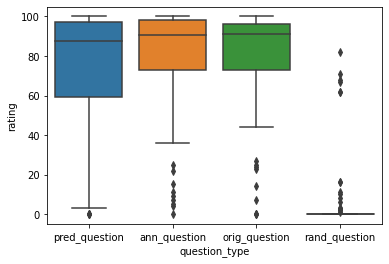

In [7]:
sns.boxplot(data=df, x = "question_type", y = "rating")
# # exclude anything where random is rated as correct
# rand_only = df[df['question_type'] == 'rand_question']
# rand_only = rand_only[rand_only['rating'] > 50]
# indices = set([x for x in rand_only['ex_ind']]) 
# print(indices)
# df_clean = df[~df['ex_ind'].isin(indices)]

# sns.boxplot(data = df_clean, x = "question_type", y="rating")

# Initial results
- some predicted questions are really bad
- some original questions are bad 
- some annotator questions are bad 
- some random questions are good but on average they're very bad 

## Significance tests
Let's run some tests to see if the means are different 


In [26]:
import scipy 

# isolate scores 
ann_only = df[df['question_type'] == 'ann_question']
orig_only = df[df['question_type']== 'orig_question']
pred_only = df[df['question_type'] == 'pred_question']
rand_only = df[df['question_type'] == 'rand_question']

to_run = [('ann', ann_only), ('orig', orig_only), ('pred', pred_only), ('rand', rand_only)]

# run pairwise t-tests 
done = []
for name1, data1 in to_run:
    for name2, data2 in to_run:
        if name1 == name2: 
            continue
        if (name1, name2) in done or (name2, name1) in done:
            continue

        # run t-test 
        d1 = data1['rating'].values
        d2 = data2['rating'].values
        mean1, mean2 = np.mean(d1), np.mean(d2)
        stat, p_value = scipy.stats.ttest_ind(d1, d2, equal_var = False)

        print(f"{name1} to {name2}")
        print(f"\t{name1} mean: {mean1}, {name2} mean: {mean2}")
        print(f"\tStat: {stat}, p_val: {p_value}")
        done.append((name1, name2))

ann to orig
	ann mean: 79.24, orig mean: 80.86
	Stat: -0.4459990734456288, p_val: 0.6560873959768669
ann to pred
	ann mean: 79.24, pred mean: 71.83
	Stat: 1.7600962155769186, p_val: 0.0800011905067198
ann to rand
	ann mean: 79.24, rand mean: 4.9
	Stat: 23.788855055644216, p_val: 2.517771199464696e-55
orig to pred
	orig mean: 80.86, pred mean: 71.83
	Stat: 2.2000795063346956, p_val: 0.02904235270687402
orig to rand
	orig mean: 80.86, rand mean: 4.9
	Stat: 25.47963483237282, p_val: 2.430854635701381e-60
pred to rand
	pred mean: 71.83, rand mean: 4.9
	Stat: 18.2715522293108, p_val: 1.3257983933529837e-39


### Means and tests
From this, we can really only conclude that the original annotations are significantly better than the predicted ones. 

## bad questions
Let's take a closer look at the bad predicted, annotator, and original questions. Are these roughly the same? 

In [24]:
pred_only = df[df['question_type'] == 'pred_question']
pred_idxs = set(pred_only[pred_only['rating'] < 30]['ex_ind'].values)
ann_only = df[df['question_type'] == 'ann_question']
ann_idxs = set(ann_only[ann_only['rating'] < 30]['ex_ind'].values)

print("pred")
print(pred_idxs)
print("ann")
print(ann_idxs)
print("both")
print(pred_idxs & ann_idxs)
print("ann but not pred")
print(ann_idxs - pred_idxs)


pred
{9, 10, 11, 15, 17, 18, 22, 23, 30, 33, 39, 53, 54, 56, 63, 73, 77, 78, 87}
ann
{33, 34, 4, 11, 78, 48, 20, 87, 56}
both
{33, 11, 78, 87, 56}
ann but not pred
{48, 34, 4, 20}


## Rankings
We can also look at the ranking to see how questions are ranked 

In [5]:
def get_ranking(df): 
    rank_count = {i: {'rand_question': 0,
                  'orig_question': 0,
                  'pred_question': 0,
                  'ann_question': 0} for i in range(4)}
    for i in range(100): 
        data = df[df['ex_ind'] == i]
        types = data['question_type']
        ratings = data['rating']
        types_and_ratings = [x for x in zip(types, ratings)]
        types_and_ratings = sorted(types_and_ratings, key=lambda x: x[1])
        for rank, (type, rating) in enumerate(types_and_ratings): 
            rank_count[rank][type] += 1
    return rank_count

rank_count = get_ranking(df)
print(rank_count)




{0: {'rand_question': 91, 'orig_question': 2, 'pred_question': 7, 'ann_question': 0}, 1: {'rand_question': 7, 'orig_question': 30, 'pred_question': 32, 'ann_question': 31}, 2: {'rand_question': 1, 'orig_question': 34, 'pred_question': 32, 'ann_question': 33}, 3: {'rand_question': 1, 'orig_question': 34, 'pred_question': 29, 'ann_question': 36}}


## Ranking results
It doesn't look like there is much a difference here for the top slots. The annotator questions win by 2 questions, but that seems unlikely to be significant.

In [8]:
rand_only = df[df['question_type'] == 'rand_question']
print(rand_only[rand_only['rating'] > 50])

     ex_ind  question_type                                  question  rating  \
ind                                                                            
139      34  rand_question                    What is the man doing?    71.0   
156      39  rand_question  What is the silver box below the mirror?    68.0   
232      58  rand_question                        Where are they at?    82.0   
287      71  rand_question        What kind of food is on the plate?    62.0   
307      76  rand_question                          Which bus it is?    67.0   
323      80  rand_question                   Where is the bus going?    62.0   

             qid  
ind               
139  405041002_5  
156  183972002_3  
232  485913002_2  
287  259717002_7  
307  387543001_6  
323  443667009_0  


In [18]:
pred_only = df[df['question_type'] == 'pred_question']
print(pred_only[pred_only['rating'] < 30])

     ex_ind  question_type                                           question  \
ind                                                                             
13        3  pred_question                         What is the body of water?   
137      34  pred_question                             What is the man doing?   
147      36  pred_question           Why are there people behind the catcher?   
235      58  pred_question                         What kind of park is this?   
254      63  pred_question     What is the job of the men on the motorcycles?   
266      66  pred_question           What is the job of the man on the right?   
275      68  pred_question                 What color is the horse's blanket?   
316      79  pred_question                       What is the green vegetable?   
349      87  pred_question  What is the bird sitting on top of that is flo...   

     rating          qid  
ind                       
13      0.0  223458004_2  
137     0.0  405041002_5  
